In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTModel

# Dataset

In [ ]:
# Mount Google Drive (only for Colab)
drive.mount('/content/drive')

# ========================================================================
# 1. Dataset Configuration
# ========================================================================
dataset_paths = {
    'Normal': '/content/drive/MyDrive/Normal and Osteoporosis Binary Classification Dataset/normal/',
    'Osteoporosis': '/content/drive/MyDrive/Normal and Osteoporosis Binary Classification Dataset/osteoporosis/'
}

# ========================================================================
# 2. Image Loading & Preprocessing
# ========================================================================
def load_images_and_labels(folder_path, label):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(folder_path, filename)
            try:
                # Load image and verify successful read
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue

                # Critical Fix 1: Resize to ViT's required 224x224
                img = cv2.resize(img, (224, 224))

                # Critical Fix 2: Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Critical Fix 3: Convert to channels-first format
                img = np.transpose(img, (2, 0, 1))  # (3, 224, 224)

                # Critical Fix 4: Normalize to [-1, 1] range
                img = (img.astype(np.float32) / 127.5) - 1.0

                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(images), np.array(labels)

# ========================================================================
# 3. Load and Prepare Data
# ========================================================================
# Load datasets
normal_images, normal_labels = load_images_and_labels(dataset_paths['Normal'], 0)
osteo_images, osteo_labels = load_images_and_labels(dataset_paths['Osteoporosis'], 1)

# Combine and shuffle data
x_data = np.concatenate([normal_images, osteo_images], axis=0)
y_data = np.concatenate([normal_labels, osteo_labels], axis=0)

# Random shuffle with fixed seed for reproducibility
np.random.seed(42)
shuffle_idx = np.random.permutation(len(x_data))
x_data = x_data[shuffle_idx]
y_data = y_data[shuffle_idx]

# ========================================================================
# 4. Train/Validation/Test Split
# ========================================================================
# Stratified split to maintain class balance
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data,
    test_size=0.2,
    stratify=y_data,
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val,
    test_size=0.1,  # 10% of training for validation
    stratify=y_train_val,
    random_state=42
)

Mounted at /content/drive


In [ ]:
print(f'Number of Normal Images: {len(normal_images)}')
print(f'Number of Oestroporosis Images: {len(osteo_images)}')

Number of Normal Images: 186
Number of Oestroporosis Images: 186


In [ ]:
# Step 2: Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 3: DWT Implementation
def dwt_haar(img):
    """Performs Haar wavelet transform on a batch of images."""
    # img shape: (batch, channels, height, width)
    batch, channels, h, w = img.shape

    # Split rows into even and odd indices
    even_rows = img[:, :, 0::2, :]
    odd_rows = img[:, :, 1::2, :]

    # Compute row-wise averages and differences
    avg_rows = (even_rows + odd_rows) / 2
    diff_rows = (even_rows - odd_rows) / 2

    # Split columns for avg_rows (LL and HL)
    even_cols_avg = avg_rows[:, :, :, 0::2]
    odd_cols_avg = avg_rows[:, :, :, 1::2]
    LL = (even_cols_avg + odd_cols_avg) / 2
    HL = (even_cols_avg - odd_cols_avg) / 2

    # Split columns for diff_rows (LH and HH)
    even_cols_diff = diff_rows[:, :, :, 0::2]
    odd_cols_diff = diff_rows[:, :, :, 1::2]
    LH = (even_cols_diff + odd_cols_diff) / 2
    HH = (even_cols_diff - odd_cols_diff) / 2

    return torch.cat([LL, HL, LH, HH], dim=1)

# Step 4: Dataset Class (unchanged)
class NumpyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.x_data[idx]).float()
        label = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return image, label

Using device: cuda


# Base ViT Model

In [ ]:
# Step 5: Modified ViT Model with DWT Processing
class ViTBinaryClassifier(nn.Module):
    def __init__(self, pretrained_model='google/vit-base-patch16-224-in21k'):
        super().__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model)
        self.classifier = nn.Linear(self.vit.config.hidden_size * 4, 1)
        self.sigmoid = nn.Sigmoid()

        # Freeze ViT parameters
        for param in self.vit.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Apply Haar DWT
        x_dwt = dwt_haar(x)
        batch_size = x_dwt.size(0)

        # Reshape and process each subband
        x_dwt = x_dwt.view(batch_size, 4, 3, 112, 112)
        vit_outputs = []

        for i in range(4):
            subband = x_dwt[:, i, :, :, :]
            subband_up = F.interpolate(subband, size=(224, 224),
                                     mode='bilinear', align_corners=False)
            outputs = self.vit(subband_up)
            vit_outputs.append(outputs.last_hidden_state[:, 0, :])

        # Concatenate and classify
        combined = torch.cat(vit_outputs, dim=1)
        return self.sigmoid(self.classifier(combined))

# Step 6: Create Datasets and DataLoaders
# (Assuming x_train, y_train, x_val, y_val, x_test, y_test are defined)
batch_size = 32
train_dataset = NumpyDataset(x_train, y_train)
val_dataset = NumpyDataset(x_val, y_val)
test_dataset = NumpyDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Step 7: Initialize Model (AFTER device is defined)
model = ViTBinaryClassifier().to(device)

# Step 8: Loss and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
import time
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Modified training loop with learning rate scheduling
num_epochs = 500
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
early_stop = False
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True
)

print(f"\n{'='*50}")
print(f"Starting training with early stopping (patience={patience})")
print(f"and learning rate scheduling (ReduceLROnPlateau)")
print(f"{'='*50}\n")

for epoch in range(num_epochs):
    if early_stop:
        print(f"[!] Early stopping triggered at epoch {epoch+1}")
        break

    epoch_start = time.time()

    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Train]") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_batches += 1

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'AvgLoss': f"{(train_loss/(train_batches*batch_size)):.4f}"
            })

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Val]  ") as pbar:
        with torch.no_grad():
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                predicted = (outputs >= 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                pbar.set_postfix({
                    'Loss': f"{loss.item():.4f}",
                    'Acc': f"{(correct/total):.4f}"
                })

    # Calculate metrics
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    current_lr = optimizer.param_groups[0]['lr']

    # Update learning rate
    scheduler.step(epoch_val_loss)

    # Store history
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Early stopping logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        improvement_msg = f"(▼ {best_val_loss - epoch_val_loss:.4f})"
    else:
        epochs_no_improve += 1
        improvement_msg = f"(▲ {epoch_val_loss - best_val_loss:.4f}) [Patience left: {patience - epochs_no_improve}]"
        if epochs_no_improve >= patience:
            early_stop = True

    # Calculate epoch duration
    epoch_time = time.time() - epoch_start
    time_remaining = (epoch_time * (num_epochs - epoch - 1)) / 3600 if not early_stop else 0

    # Detailed epoch report
    print(f"\nEpoch {epoch+1:3d}/{num_epochs} | Duration: {epoch_time:.1f}s | Remaining: ~{time_remaining:.1f}h")
    print(f"Train Loss: {epoch_train_loss:.4f}")
    print(f"Val Loss:   {epoch_val_loss:.4f} {improvement_msg}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"-"*60)

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("\nLoaded best model weights for final testing")

# Final evaluation
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

with tqdm(test_loader, unit="batch", desc="Final Testing") as pbar:
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            predicted = (outputs >= 0.5).float()
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Acc': f"{(test_correct/test_total):.4f}"
            })

print(f"\n{'='*50}")
print(f"Final Test Results:")
print(f"Loss: {test_loss/len(test_dataset):.4f}")
print(f"Accuracy: {test_correct/test_total:.4f}")
print(f"{'='*50}")


Starting training with early stopping (patience=20)
and learning rate scheduling (ReduceLROnPlateau)



Epoch   1/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.58s/batch, Loss=0.4702, Acc=0.7667]



Epoch   1/500 | Duration: 14.6s | Remaining: ~2.0h
Train Loss: 0.4543
Val Loss:   0.4702 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   2/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.64s/batch, Loss=0.4634, Acc=0.8000]



Epoch   2/500 | Duration: 15.1s | Remaining: ~2.1h
Train Loss: 0.4490
Val Loss:   0.4634 (▼ 0.0000)
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   3/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.63s/batch, Loss=0.4607, Acc=0.7667]



Epoch   3/500 | Duration: 15.2s | Remaining: ~2.1h
Train Loss: 0.4319
Val Loss:   0.4607 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   4/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.56s/batch, Loss=0.4578, Acc=0.7667]



Epoch   4/500 | Duration: 14.6s | Remaining: ~2.0h
Train Loss: 0.4322
Val Loss:   0.4578 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   5/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.54s/batch, Loss=0.4616, Acc=0.7333]



Epoch   5/500 | Duration: 13.6s | Remaining: ~1.9h
Train Loss: 0.4235
Val Loss:   0.4616 (▲ 0.0037) [Patience left: 19]
Val Acc:    0.7333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   6/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.55s/batch, Loss=0.4603, Acc=0.7667]



Epoch   6/500 | Duration: 13.5s | Remaining: ~1.9h
Train Loss: 0.4150
Val Loss:   0.4603 (▲ 0.0024) [Patience left: 18]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   7/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.61s/batch, Loss=0.4644, Acc=0.7667]



Epoch   7/500 | Duration: 13.8s | Remaining: ~1.9h
Train Loss: 0.4098
Val Loss:   0.4644 (▲ 0.0066) [Patience left: 17]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   8/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.64s/batch, Loss=0.4638, Acc=0.7667]



Epoch   8/500 | Duration: 14.0s | Remaining: ~1.9h
Train Loss: 0.4032
Val Loss:   0.4638 (▲ 0.0060) [Patience left: 16]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   9/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.62s/batch, Loss=0.4640, Acc=0.7667]



Epoch   9/500 | Duration: 14.0s | Remaining: ~1.9h
Train Loss: 0.3991
Val Loss:   0.4640 (▲ 0.0062) [Patience left: 15]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  10/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.61s/batch, Loss=0.4634, Acc=0.7667]



Epoch  10/500 | Duration: 13.9s | Remaining: ~1.9h
Train Loss: 0.3941
Val Loss:   0.4634 (▲ 0.0056) [Patience left: 14]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  11/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.59s/batch, Loss=0.4636, Acc=0.7333]



Epoch  11/500 | Duration: 13.8s | Remaining: ~1.9h
Train Loss: 0.3896
Val Loss:   0.4636 (▲ 0.0058) [Patience left: 13]
Val Acc:    0.7333
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  12/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.63s/batch, Loss=0.4640, Acc=0.7333]



Epoch  12/500 | Duration: 13.8s | Remaining: ~1.9h
Train Loss: 0.3885
Val Loss:   0.4640 (▲ 0.0062) [Patience left: 12]
Val Acc:    0.7333
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  13/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.61s/batch, Loss=0.4643, Acc=0.7333]



Epoch  13/500 | Duration: 13.9s | Remaining: ~1.9h
Train Loss: 0.3882
Val Loss:   0.4643 (▲ 0.0065) [Patience left: 11]
Val Acc:    0.7333
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  14/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.61s/batch, Loss=0.4646, Acc=0.7333]



Epoch  14/500 | Duration: 13.9s | Remaining: ~1.9h
Train Loss: 0.3880
Val Loss:   0.4646 (▲ 0.0068) [Patience left: 10]
Val Acc:    0.7333
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  15/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.61s/batch, Loss=0.4652, Acc=0.7333]



Epoch  15/500 | Duration: 13.9s | Remaining: ~1.9h
Train Loss: 0.3869
Val Loss:   0.4652 (▲ 0.0074) [Patience left: 9]
Val Acc:    0.7333
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  16/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.63s/batch, Loss=0.4654, Acc=0.7333]



Epoch  16/500 | Duration: 13.9s | Remaining: ~1.9h
Train Loss: 0.3867
Val Loss:   0.4654 (▲ 0.0076) [Patience left: 8]
Val Acc:    0.7333
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  17/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.60s/batch, Loss=0.4654, Acc=0.7333]



Epoch  17/500 | Duration: 13.9s | Remaining: ~1.9h
Train Loss: 0.3862
Val Loss:   0.4654 (▲ 0.0076) [Patience left: 7]
Val Acc:    0.7333
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  18/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.61s/batch, Loss=0.4654, Acc=0.7333]



Epoch  18/500 | Duration: 13.9s | Remaining: ~1.9h
Train Loss: 0.3861
Val Loss:   0.4654 (▲ 0.0076) [Patience left: 6]
Val Acc:    0.7333
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  19/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.59s/batch, Loss=0.4654, Acc=0.7333]



Epoch  19/500 | Duration: 13.8s | Remaining: ~1.8h
Train Loss: 0.3860
Val Loss:   0.4654 (▲ 0.0076) [Patience left: 5]
Val Acc:    0.7333
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  20/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.61s/batch, Loss=0.4654, Acc=0.7333]



Epoch  20/500 | Duration: 13.9s | Remaining: ~1.9h
Train Loss: 0.3860
Val Loss:   0.4654 (▲ 0.0076) [Patience left: 4]
Val Acc:    0.7333
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  21/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.59s/batch, Loss=0.4654, Acc=0.7333]



Epoch  21/500 | Duration: 13.9s | Remaining: ~1.9h
Train Loss: 0.3860
Val Loss:   0.4654 (▲ 0.0076) [Patience left: 3]
Val Acc:    0.7333
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  22/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.61s/batch, Loss=0.4654, Acc=0.7333]



Epoch  22/500 | Duration: 13.9s | Remaining: ~1.8h
Train Loss: 0.3859
Val Loss:   0.4654 (▲ 0.0076) [Patience left: 2]
Val Acc:    0.7333
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  23/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.60s/batch, Loss=0.4654, Acc=0.7333]



Epoch  23/500 | Duration: 13.9s | Remaining: ~1.8h
Train Loss: 0.3858
Val Loss:   0.4654 (▲ 0.0076) [Patience left: 1]
Val Acc:    0.7333
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  24/500 [Val]  : 100%|██████████| 1/1 [00:01<00:00,  1.61s/batch, Loss=0.4654, Acc=0.7333]
<ipython-input-8-58b9b85997b7>:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu


Epoch  24/500 | Duration: 13.9s | Remaining: ~0.0h
Train Loss: 0.3858
Val Loss:   0.4654 (▲ 0.0076) [Patience left: 0]
Val Acc:    0.7333
Learning Rate: 1.00e-06
------------------------------------------------------------
[!] Early stopping triggered at epoch 25

Loaded best model weights for final testing


Final Testing: 100%|██████████| 3/3 [00:03<00:00,  1.18s/batch, Loss=0.4251, Acc=0.6933]


Final Test Results:
Loss: 0.5616
Accuracy: 0.6933


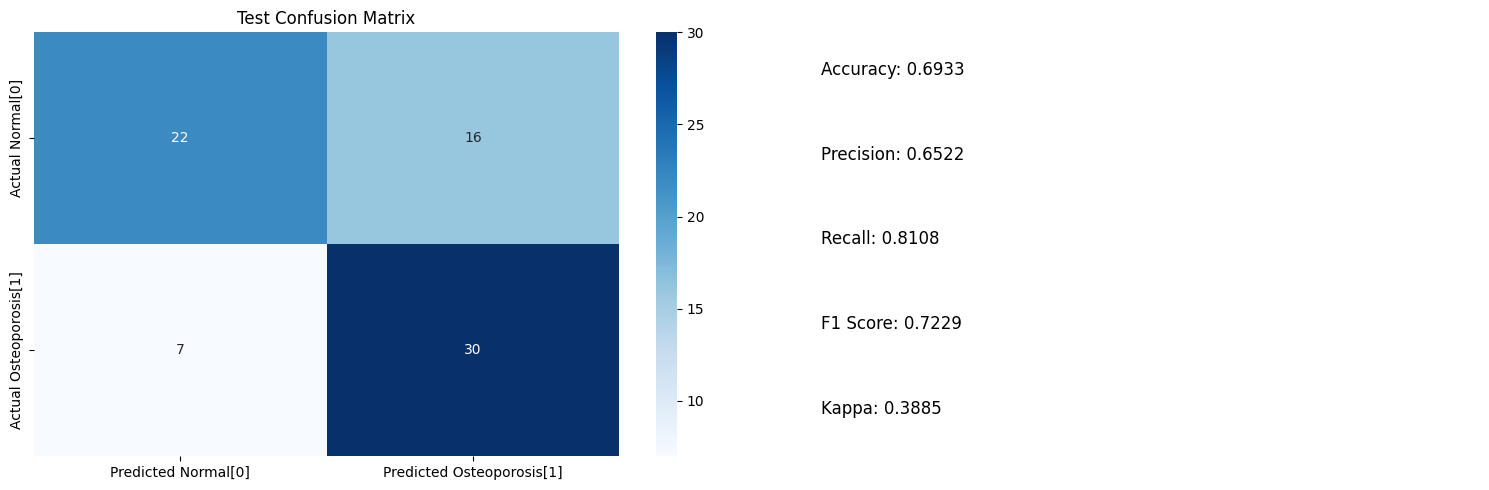

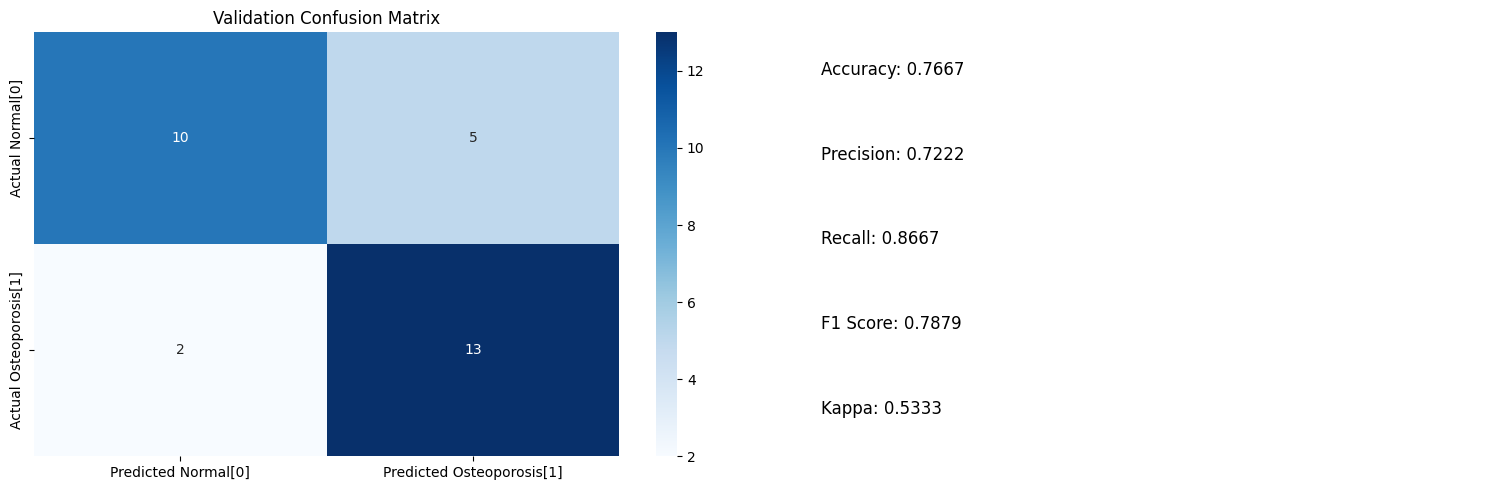

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# For accuracy graph (assuming you have training history)
train_accuracies = []  # Populate these during training
val_accuracies = []    # Populate these during validation

def plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa):
    plt.figure(figsize=(15, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal[0]', 'Predicted Osteoporosis[1]'],
                yticklabels=['Actual Normal[0]', 'Actual Osteoporosis[1]'])
    plt.title(f'{phase_name} Confusion Matrix')

    # Metrics Text
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, f'Accuracy: {accuracy:.4f}', fontsize=12)
    plt.text(0.1, 0.7, f'Precision: {precision:.4f}', fontsize=12)
    plt.text(0.1, 0.5, f'Recall: {recall:.4f}', fontsize=12)
    plt.text(0.1, 0.3, f'F1 Score: {f1:.4f}', fontsize=12)
    plt.text(0.1, 0.1, f"Kappa: {kappa:.4f}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_model(loader, phase_name):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            preds = (outputs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa)

    return accuracy



# Evaluate both sets
test_accuracy = evaluate_model(test_loader, 'Test')
val_accuracy = evaluate_model(val_loader, 'Validation')


# ViT Large Model

In [ ]:
# Step 5: Modified ViT Model with DWT Processing
class ViTBinaryClassifier(nn.Module):
    def __init__(self, pretrained_model='google/vit-large-patch16-224-in21k'):
        super().__init__()
        self.vit = ViTModel.from_pretrained(pretrained_model)
        self.classifier = nn.Linear(self.vit.config.hidden_size * 4, 1)
        self.sigmoid = nn.Sigmoid()

        # Freeze ViT parameters
        for param in self.vit.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Apply Haar DWT
        x_dwt = dwt_haar(x)
        batch_size = x_dwt.size(0)

        # Reshape and process each subband
        x_dwt = x_dwt.view(batch_size, 4, 3, 112, 112)
        vit_outputs = []

        for i in range(4):
            subband = x_dwt[:, i, :, :, :]
            subband_up = F.interpolate(subband, size=(224, 224),
                                     mode='bilinear', align_corners=False)
            outputs = self.vit(subband_up)
            vit_outputs.append(outputs.last_hidden_state[:, 0, :])

        # Concatenate and classify
        combined = torch.cat(vit_outputs, dim=1)
        return self.sigmoid(self.classifier(combined))

# Step 6: Create Datasets and DataLoaders
# (Assuming x_train, y_train, x_val, y_val, x_test, y_test are defined)
batch_size = 32
train_dataset = NumpyDataset(x_train, y_train)
val_dataset = NumpyDataset(x_val, y_val)
test_dataset = NumpyDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Step 7: Initialize Model (AFTER device is defined)
model = ViTBinaryClassifier().to(device)

# Step 8: Loss and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [ ]:
import time
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Modified training loop with learning rate scheduling
num_epochs = 500
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0
early_stop = False
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'lr': []}

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True
)

print(f"\n{'='*50}")
print(f"Starting training with early stopping (patience={patience})")
print(f"and learning rate scheduling (ReduceLROnPlateau)")
print(f"{'='*50}\n")

for epoch in range(num_epochs):
    if early_stop:
        print(f"[!] Early stopping triggered at epoch {epoch+1}")
        break

    epoch_start = time.time()

    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Train]") as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_batches += 1

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'AvgLoss': f"{(train_loss/(train_batches*batch_size)):.4f}"
            })

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch", desc=f"Epoch {epoch+1:3d}/{num_epochs} [Val]  ") as pbar:
        with torch.no_grad():
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                predicted = (outputs >= 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                pbar.set_postfix({
                    'Loss': f"{loss.item():.4f}",
                    'Acc': f"{(correct/total):.4f}"
                })

    # Calculate metrics
    epoch_train_loss = train_loss / len(train_dataset)
    epoch_val_loss = val_loss / len(val_dataset)
    val_acc = correct / total
    current_lr = optimizer.param_groups[0]['lr']

    # Update learning rate
    scheduler.step(epoch_val_loss)

    # Store history
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Early stopping logic
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        improvement_msg = f"(▼ {best_val_loss - epoch_val_loss:.4f})"
    else:
        epochs_no_improve += 1
        improvement_msg = f"(▲ {epoch_val_loss - best_val_loss:.4f}) [Patience left: {patience - epochs_no_improve}]"
        if epochs_no_improve >= patience:
            early_stop = True

    # Calculate epoch duration
    epoch_time = time.time() - epoch_start
    time_remaining = (epoch_time * (num_epochs - epoch - 1)) / 3600 if not early_stop else 0

    # Detailed epoch report
    print(f"\nEpoch {epoch+1:3d}/{num_epochs} | Duration: {epoch_time:.1f}s | Remaining: ~{time_remaining:.1f}h")
    print(f"Train Loss: {epoch_train_loss:.4f}")
    print(f"Val Loss:   {epoch_val_loss:.4f} {improvement_msg}")
    print(f"Val Acc:    {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")
    print(f"-"*60)

# Load best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("\nLoaded best model weights for final testing")

# Final evaluation
model.eval()
test_correct = 0
test_total = 0
test_loss = 0.0

with tqdm(test_loader, unit="batch", desc="Final Testing") as pbar:
    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            predicted = (outputs >= 0.5).float()
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Acc': f"{(test_correct/test_total):.4f}"
            })

print(f"\n{'='*50}")
print(f"Final Test Results:")
print(f"Loss: {test_loss/len(test_dataset):.4f}")
print(f"Accuracy: {test_correct/test_total:.4f}")
print(f"{'='*50}")


Starting training with early stopping (patience=20)
and learning rate scheduling (ReduceLROnPlateau)



Epoch   1/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.46s/batch, Loss=0.5395, Acc=0.7000]



Epoch   1/500 | Duration: 46.1s | Remaining: ~6.4h
Train Loss: 0.6860
Val Loss:   0.5395 (▼ 0.0000)
Val Acc:    0.7000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   2/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.38s/batch, Loss=0.4685, Acc=0.7333]



Epoch   2/500 | Duration: 52.2s | Remaining: ~7.2h
Train Loss: 0.5667
Val Loss:   0.4685 (▼ 0.0000)
Val Acc:    0.7333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   3/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.51s/batch, Loss=0.4417, Acc=0.7667]



Epoch   3/500 | Duration: 56.0s | Remaining: ~7.7h
Train Loss: 0.5388
Val Loss:   0.4417 (▼ 0.0000)
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   4/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.56s/batch, Loss=0.4476, Acc=0.7667]



Epoch   4/500 | Duration: 42.6s | Remaining: ~5.9h
Train Loss: 0.5211
Val Loss:   0.4476 (▲ 0.0059) [Patience left: 19]
Val Acc:    0.7667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   5/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.37s/batch, Loss=0.4153, Acc=0.8333]



Epoch   5/500 | Duration: 52.1s | Remaining: ~7.2h
Train Loss: 0.4995
Val Loss:   0.4153 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   6/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.54s/batch, Loss=0.4059, Acc=0.8333]



Epoch   6/500 | Duration: 55.8s | Remaining: ~7.7h
Train Loss: 0.4750
Val Loss:   0.4059 (▼ 0.0000)
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   7/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.45s/batch, Loss=0.4045, Acc=0.8667]



Epoch   7/500 | Duration: 50.6s | Remaining: ~6.9h
Train Loss: 0.4407
Val Loss:   0.4045 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   8/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.58s/batch, Loss=0.3963, Acc=0.8667]



Epoch   8/500 | Duration: 47.5s | Remaining: ~6.5h
Train Loss: 0.4289
Val Loss:   0.3963 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch   9/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.44s/batch, Loss=0.4069, Acc=0.8333]



Epoch   9/500 | Duration: 42.2s | Remaining: ~5.8h
Train Loss: 0.4256
Val Loss:   0.4069 (▲ 0.0106) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  10/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.45s/batch, Loss=0.3785, Acc=0.8667]



Epoch  10/500 | Duration: 54.1s | Remaining: ~7.4h
Train Loss: 0.4093
Val Loss:   0.3785 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  11/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.56s/batch, Loss=0.3974, Acc=0.8667]



Epoch  11/500 | Duration: 43.0s | Remaining: ~5.8h
Train Loss: 0.4060
Val Loss:   0.3974 (▲ 0.0189) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  12/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.45s/batch, Loss=0.3680, Acc=0.9333]



Epoch  12/500 | Duration: 49.1s | Remaining: ~6.7h
Train Loss: 0.3883
Val Loss:   0.3680 (▼ 0.0000)
Val Acc:    0.9333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  13/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.51s/batch, Loss=0.3879, Acc=0.8333]



Epoch  13/500 | Duration: 42.7s | Remaining: ~5.8h
Train Loss: 0.3954
Val Loss:   0.3879 (▲ 0.0199) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  14/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.43s/batch, Loss=0.3796, Acc=0.8667]



Epoch  14/500 | Duration: 42.3s | Remaining: ~5.7h
Train Loss: 0.3860
Val Loss:   0.3796 (▲ 0.0116) [Patience left: 18]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  15/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.41s/batch, Loss=0.3605, Acc=0.8667]



Epoch  15/500 | Duration: 51.0s | Remaining: ~6.9h
Train Loss: 0.3660
Val Loss:   0.3605 (▼ 0.0000)
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  16/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.50s/batch, Loss=0.3737, Acc=0.8667]



Epoch  16/500 | Duration: 43.3s | Remaining: ~5.8h
Train Loss: 0.3547
Val Loss:   0.3737 (▲ 0.0131) [Patience left: 19]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  17/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.39s/batch, Loss=0.3443, Acc=0.9333]



Epoch  17/500 | Duration: 54.5s | Remaining: ~7.3h
Train Loss: 0.3484
Val Loss:   0.3443 (▼ 0.0000)
Val Acc:    0.9333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  18/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.58s/batch, Loss=0.3669, Acc=0.8333]



Epoch  18/500 | Duration: 43.6s | Remaining: ~5.8h
Train Loss: 0.3412
Val Loss:   0.3669 (▲ 0.0226) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  19/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.32s/batch, Loss=0.3656, Acc=0.8000]



Epoch  19/500 | Duration: 42.0s | Remaining: ~5.6h
Train Loss: 0.3385
Val Loss:   0.3656 (▲ 0.0213) [Patience left: 18]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  20/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.48s/batch, Loss=0.3428, Acc=0.9000]



Epoch  20/500 | Duration: 48.5s | Remaining: ~6.5h
Train Loss: 0.3365
Val Loss:   0.3428 (▼ 0.0000)
Val Acc:    0.9000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  21/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.48s/batch, Loss=0.3648, Acc=0.8000]



Epoch  21/500 | Duration: 42.7s | Remaining: ~5.7h
Train Loss: 0.3253
Val Loss:   0.3648 (▲ 0.0220) [Patience left: 19]
Val Acc:    0.8000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  22/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.39s/batch, Loss=0.3386, Acc=0.9333]



Epoch  22/500 | Duration: 51.0s | Remaining: ~6.8h
Train Loss: 0.3167
Val Loss:   0.3386 (▼ 0.0000)
Val Acc:    0.9333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  23/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.49s/batch, Loss=0.3560, Acc=0.8333]



Epoch  23/500 | Duration: 43.0s | Remaining: ~5.7h
Train Loss: 0.3105
Val Loss:   0.3560 (▲ 0.0174) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  24/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.47s/batch, Loss=0.3537, Acc=0.8667]



Epoch  24/500 | Duration: 42.3s | Remaining: ~5.6h
Train Loss: 0.3072
Val Loss:   0.3537 (▲ 0.0150) [Patience left: 18]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  25/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.43s/batch, Loss=0.3349, Acc=0.9333]



Epoch  25/500 | Duration: 50.3s | Remaining: ~6.6h
Train Loss: 0.3001
Val Loss:   0.3349 (▼ 0.0000)
Val Acc:    0.9333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  26/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.57s/batch, Loss=0.3439, Acc=0.8333]



Epoch  26/500 | Duration: 43.1s | Remaining: ~5.7h
Train Loss: 0.3000
Val Loss:   0.3439 (▲ 0.0090) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  27/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.36s/batch, Loss=0.3356, Acc=0.8667]



Epoch  27/500 | Duration: 41.9s | Remaining: ~5.5h
Train Loss: 0.2904
Val Loss:   0.3356 (▲ 0.0007) [Patience left: 18]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  28/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.42s/batch, Loss=0.3503, Acc=0.8333]



Epoch  28/500 | Duration: 42.4s | Remaining: ~5.6h
Train Loss: 0.2857
Val Loss:   0.3503 (▲ 0.0154) [Patience left: 17]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  29/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.46s/batch, Loss=0.3225, Acc=0.9667]



Epoch  29/500 | Duration: 50.4s | Remaining: ~6.6h
Train Loss: 0.2903
Val Loss:   0.3225 (▼ 0.0000)
Val Acc:    0.9667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  30/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.53s/batch, Loss=0.3453, Acc=0.8333]



Epoch  30/500 | Duration: 43.0s | Remaining: ~5.6h
Train Loss: 0.2883
Val Loss:   0.3453 (▲ 0.0228) [Patience left: 19]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  31/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.42s/batch, Loss=0.3238, Acc=0.9333]



Epoch  31/500 | Duration: 42.1s | Remaining: ~5.5h
Train Loss: 0.2743
Val Loss:   0.3238 (▲ 0.0013) [Patience left: 18]
Val Acc:    0.9333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  32/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.46s/batch, Loss=0.3373, Acc=0.8333]



Epoch  32/500 | Duration: 42.4s | Remaining: ~5.5h
Train Loss: 0.2709
Val Loss:   0.3373 (▲ 0.0147) [Patience left: 17]
Val Acc:    0.8333
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  33/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.42s/batch, Loss=0.3241, Acc=0.9000]



Epoch  33/500 | Duration: 42.4s | Remaining: ~5.5h
Train Loss: 0.2633
Val Loss:   0.3241 (▲ 0.0016) [Patience left: 16]
Val Acc:    0.9000
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  34/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.54s/batch, Loss=0.3368, Acc=0.8667]



Epoch  34/500 | Duration: 42.3s | Remaining: ~5.5h
Train Loss: 0.2644
Val Loss:   0.3368 (▲ 0.0143) [Patience left: 15]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  35/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.38s/batch, Loss=0.3330, Acc=0.8667]



Epoch  35/500 | Duration: 42.4s | Remaining: ~5.5h
Train Loss: 0.2612
Val Loss:   0.3330 (▲ 0.0104) [Patience left: 14]
Val Acc:    0.8667
Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch  36/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.44s/batch, Loss=0.3268, Acc=0.8667]



Epoch  36/500 | Duration: 42.3s | Remaining: ~5.4h
Train Loss: 0.2535
Val Loss:   0.3268 (▲ 0.0042) [Patience left: 13]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  37/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.48s/batch, Loss=0.3246, Acc=0.9000]



Epoch  37/500 | Duration: 42.6s | Remaining: ~5.5h
Train Loss: 0.2524
Val Loss:   0.3246 (▲ 0.0020) [Patience left: 12]
Val Acc:    0.9000
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  38/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.43s/batch, Loss=0.3266, Acc=0.8667]



Epoch  38/500 | Duration: 42.1s | Remaining: ~5.4h
Train Loss: 0.2521
Val Loss:   0.3266 (▲ 0.0041) [Patience left: 11]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  39/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.43s/batch, Loss=0.3261, Acc=0.9000]



Epoch  39/500 | Duration: 42.4s | Remaining: ~5.4h
Train Loss: 0.2518
Val Loss:   0.3261 (▲ 0.0035) [Patience left: 10]
Val Acc:    0.9000
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  40/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.42s/batch, Loss=0.3279, Acc=0.8667]



Epoch  40/500 | Duration: 42.2s | Remaining: ~5.4h
Train Loss: 0.2513
Val Loss:   0.3279 (▲ 0.0053) [Patience left: 9]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  41/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.46s/batch, Loss=0.3289, Acc=0.8667]



Epoch  41/500 | Duration: 42.4s | Remaining: ~5.4h
Train Loss: 0.2510
Val Loss:   0.3289 (▲ 0.0064) [Patience left: 8]
Val Acc:    0.8667
Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch  42/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.41s/batch, Loss=0.3287, Acc=0.8667]



Epoch  42/500 | Duration: 42.4s | Remaining: ~5.4h
Train Loss: 0.2504
Val Loss:   0.3287 (▲ 0.0061) [Patience left: 7]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  43/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.48s/batch, Loss=0.3284, Acc=0.8667]



Epoch  43/500 | Duration: 42.2s | Remaining: ~5.4h
Train Loss: 0.2504
Val Loss:   0.3284 (▲ 0.0059) [Patience left: 6]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  44/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.43s/batch, Loss=0.3293, Acc=0.8667]



Epoch  44/500 | Duration: 42.4s | Remaining: ~5.4h
Train Loss: 0.2505
Val Loss:   0.3293 (▲ 0.0067) [Patience left: 5]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  45/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.43s/batch, Loss=0.3292, Acc=0.8667]



Epoch  45/500 | Duration: 42.4s | Remaining: ~5.4h
Train Loss: 0.2503
Val Loss:   0.3292 (▲ 0.0067) [Patience left: 4]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  46/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.43s/batch, Loss=0.3288, Acc=0.8667]



Epoch  46/500 | Duration: 42.4s | Remaining: ~5.3h
Train Loss: 0.2503
Val Loss:   0.3288 (▲ 0.0062) [Patience left: 3]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  47/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.44s/batch, Loss=0.3287, Acc=0.8667]



Epoch  47/500 | Duration: 42.3s | Remaining: ~5.3h
Train Loss: 0.2502
Val Loss:   0.3287 (▲ 0.0061) [Patience left: 2]
Val Acc:    0.8667
Learning Rate: 1.00e-05
------------------------------------------------------------


Epoch  48/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.44s/batch, Loss=0.3287, Acc=0.8667]



Epoch  48/500 | Duration: 42.6s | Remaining: ~5.3h
Train Loss: 0.2502
Val Loss:   0.3287 (▲ 0.0062) [Patience left: 1]
Val Acc:    0.8667
Learning Rate: 1.00e-06
------------------------------------------------------------


Epoch  49/500 [Val]  : 100%|██████████| 1/1 [00:04<00:00,  4.50s/batch, Loss=0.3287, Acc=0.8667]
<ipython-input-16-58b9b85997b7>:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat


Epoch  49/500 | Duration: 42.5s | Remaining: ~0.0h
Train Loss: 0.2502
Val Loss:   0.3287 (▲ 0.0061) [Patience left: 0]
Val Acc:    0.8667
Learning Rate: 1.00e-06
------------------------------------------------------------
[!] Early stopping triggered at epoch 50

Loaded best model weights for final testing


Final Testing: 100%|██████████| 3/3 [00:10<00:00,  3.63s/batch, Loss=0.5342, Acc=0.7733]


Final Test Results:
Loss: 0.4793
Accuracy: 0.7733


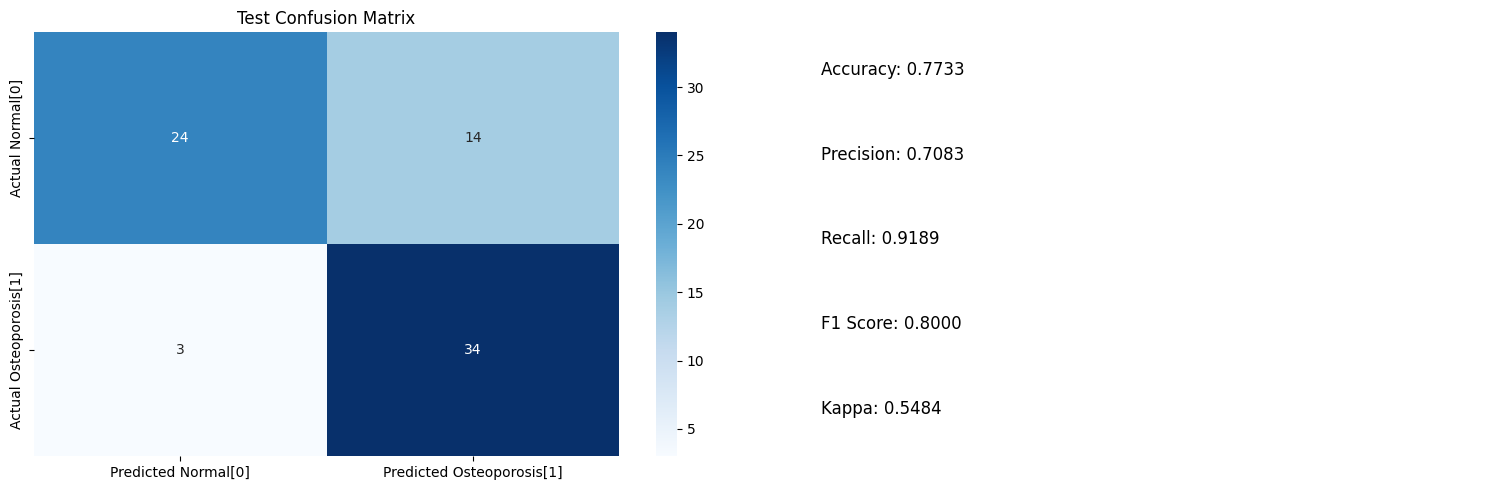

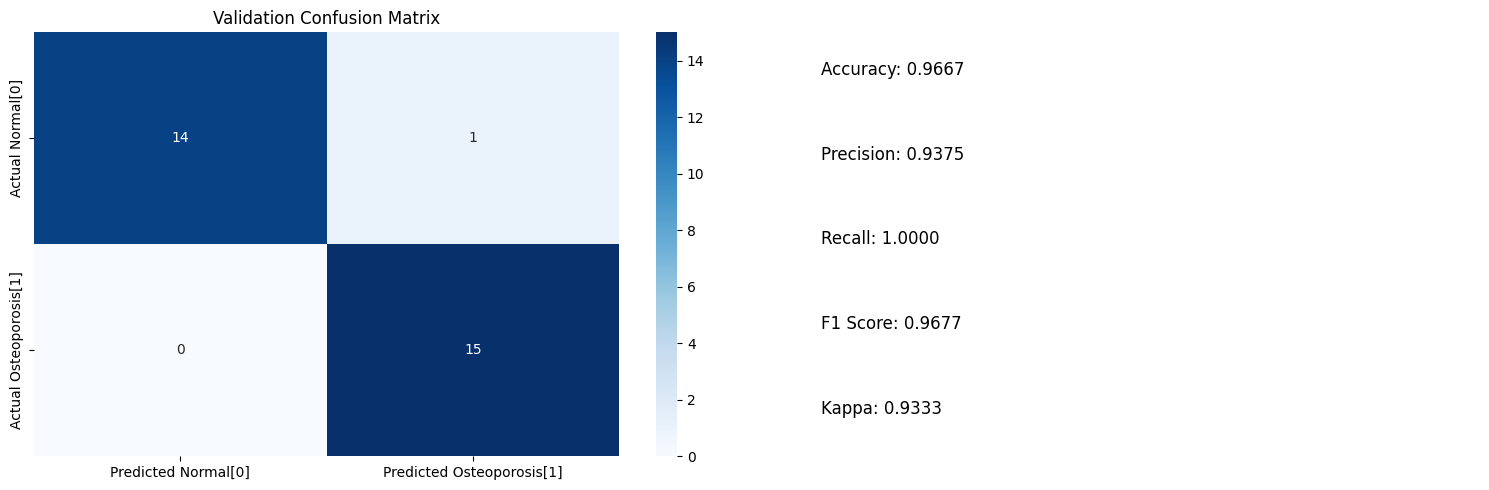

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# For accuracy graph (assuming you have training history)
train_accuracies = []  # Populate these during training
val_accuracies = []    # Populate these during validation

def plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa):
    plt.figure(figsize=(15, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Normal[0]', 'Predicted Osteoporosis[1]'],
                yticklabels=['Actual Normal[0]', 'Actual Osteoporosis[1]'])
    plt.title(f'{phase_name} Confusion Matrix')

    # Metrics Text
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.9, f'Accuracy: {accuracy:.4f}', fontsize=12)
    plt.text(0.1, 0.7, f'Precision: {precision:.4f}', fontsize=12)
    plt.text(0.1, 0.5, f'Recall: {recall:.4f}', fontsize=12)
    plt.text(0.1, 0.3, f'F1 Score: {f1:.4f}', fontsize=12)
    plt.text(0.1, 0.1, f"Kappa: {kappa:.4f}", fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_model(loader, phase_name):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            preds = (outputs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    plot_metrics(phase_name, cm, accuracy, precision, recall, f1, kappa)

    return accuracy



# Evaluate both sets
test_accuracy = evaluate_model(test_loader, 'Test')
val_accuracy = evaluate_model(val_loader, 'Validation')
